## Janus

In [1]:
import torch
from transformers import AutoConfig, AutoModelForCausalLM
from janus.models import MultiModalityCausalLM, VLChatProcessor
from janus.utils.io import load_pil_images
from PIL import Image

import numpy as np
import os
import time
from Upsample import RealESRGAN
import spaces

/home/himanshulalarya/miniconda3/envs/test/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Python version is above 3.10, patching the collections module.


/home/himanshulalarya/miniconda3/envs/test/lib/python3.10/site-packages/transformers/models/auto/image_processing_auto.py:590: FutureWarning: The image_processor_class argument is deprecated and will be removed in v4.42. Please use `slow_image_processor_class`, or `fast_image_processor_class` instead
  warnings.warn(


In [2]:
# Load model and processor
model_path = "deepseek-ai/Janus-Pro-7B"
config = AutoConfig.from_pretrained(model_path)
language_config = config.language_config
language_config._attn_implementation = 'eager'
vl_gpt = AutoModelForCausalLM.from_pretrained(model_path,
                                             language_config=language_config,
                                             trust_remote_code=True)
if torch.cuda.is_available():
    vl_gpt = vl_gpt.to(torch.bfloat16).cuda()
else:
    vl_gpt = vl_gpt.to(torch.float16)

vl_chat_processor = VLChatProcessor.from_pretrained(model_path)
tokenizer = vl_chat_processor.tokenizer
cuda_device = 'cuda' if torch.cuda.is_available() else 'cpu'

# SR model
sr_model = RealESRGAN(torch.device('cuda' if torch.cuda.is_available() else 'cpu'), scale=2)
sr_model.load_weights(f'weights/RealESRGAN_x2.pth', download=True)


Loading checkpoint shards: 100%|██████████| 2/2 [00:10<00:00,  5.31s/it]
Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.
Some kwargs in processor config are unused 

In [39]:
def generate(input_ids,
             width,
             height,
             temperature: float = 1,
             parallel_size: int = 5,
             cfg_weight: float = 5,
             image_token_num_per_image: int = 576,
             patch_size: int = 16):
    # Clear CUDA cache before generating
    torch.cuda.empty_cache()
    
    tokens = torch.zeros((parallel_size * 2, len(input_ids)), dtype=torch.int).to(cuda_device)
    for i in range(parallel_size * 2):
        tokens[i, :] = input_ids
        if i % 2 != 0:
            tokens[i, 1:-1] = vl_chat_processor.pad_id
    inputs_embeds = vl_gpt.language_model.get_input_embeddings()(tokens)
    generated_tokens = torch.zeros((parallel_size, image_token_num_per_image), dtype=torch.int).to(cuda_device)

    pkv = None
    for i in range(image_token_num_per_image):
        with torch.no_grad():
            outputs = vl_gpt.language_model.model(inputs_embeds=inputs_embeds,
                                                use_cache=True,
                                                past_key_values=pkv)
            pkv = outputs.past_key_values
            hidden_states = outputs.last_hidden_state
            logits = vl_gpt.gen_head(hidden_states[:, -1, :])
            logit_cond = logits[0::2, :]
            logit_uncond = logits[1::2, :]
            logits = logit_uncond + cfg_weight * (logit_cond - logit_uncond)
            probs = torch.softmax(logits / temperature, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)
            generated_tokens[:, i] = next_token.squeeze(dim=-1)
            next_token = torch.cat([next_token.unsqueeze(dim=1), next_token.unsqueeze(dim=1)], dim=1).view(-1)

            img_embeds = vl_gpt.prepare_gen_img_embeds(next_token)
            inputs_embeds = img_embeds.unsqueeze(dim=1)

    

    patches = vl_gpt.gen_vision_model.decode_code(generated_tokens.to(dtype=torch.int),
                                                 shape=[parallel_size, 8, width // patch_size, height // patch_size])

    return generated_tokens.to(dtype=torch.int), patches

def unpack(dec, width, height, parallel_size=5):
    dec = dec.to(torch.float32).cpu().numpy().transpose(0, 2, 3, 1)
    dec = np.clip((dec + 1) / 2 * 255, 0, 255)

    visual_img = np.zeros((parallel_size, width, height, 3), dtype=np.uint8)
    visual_img[:, :, :] = dec

    return visual_img

def image_upsample(img: Image.Image) -> Image.Image:
    if img is None:
        raise Exception("Image not uploaded")
    
    width, height = img.size
    
    if width >= 5000 or height >= 5000:
        raise Exception("The image is too large.")

    global sr_model
    result = sr_model.predict(img.convert('RGB'))
    # Stage 2: Upscale from 768x768 to 1024x1024 (can be done with bicubic resizing)
    result = result.resize((1024, 1024), Image.Resampling.LANCZOS)  
    return result

In [40]:
def generate_image(prompt,
                   seed=None,
                   guidance=3.5,
                   t2i_temperature=1.0):
    # Clear CUDA cache and avoid tracking gradients
    torch.cuda.empty_cache()
    # Set the seed for reproducible results
    if seed is not None:
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        np.random.seed(seed)
    width = 384
    height = 384
    parallel_size = 1
    
    with torch.no_grad():
        messages = [{'role': '<|User|>', 'content': prompt},
                    {'role': '<|Assistant|>', 'content': ''}]
        text = vl_chat_processor.apply_sft_template_for_multi_turn_prompts(conversations=messages,
                                                                   sft_format=vl_chat_processor.sft_format,
                                                                   system_prompt='')
        text = text + vl_chat_processor.image_start_tag
        
        input_ids = torch.LongTensor(tokenizer.encode(text))
        output, patches = generate(input_ids,
                                   width // 16 * 16,
                                   height // 16 * 16,
                                   cfg_weight=guidance,
                                   parallel_size=parallel_size,
                                   temperature=t2i_temperature)
        images = unpack(patches,
                        width // 16 * 16,
                        height // 16 * 16,
                        parallel_size=parallel_size)

        # return [Image.fromarray(images[i]).resize((768, 768), Image.LANCZOS) for i in range(parallel_size)]
        # stime = time.time()
        ret_images = [image_upsample(Image.fromarray(images[i])) for i in range(parallel_size)]
        # print(f'upsample time: {time.time() - stime}')
        return ret_images

        # return images

In [41]:
prompt = """(Portrait by Takashi Kijima and Lisa Barnard:1.2), award winning, Barioth , (aesthetic of hyperpop art with rippling atmosphere:0.5), fog, total clarity, f/1.4, symmetry and balance, avant-garde sublime opus magnum with splendid details, (salmon and phthalo turquoise colors:0.1), 
(Faye Wray:1.3), , 100mm f/2.8 macro lens, highly detailed,by Jocelyn Hobbie and Charles Dwyer, Triadic color guide,Leica Q2 with Summilux 28mm f/1.7 ASPH, ,clear face, Ultra High Resolution, wallpaper, 8K,Rich texture details, hyper detailed, detailed eyes, detailed background, dramatic angle, epic composition, SimplepositiveXLv1 (masterpiece, high quality, ),, solo, model photoshoot, (black theme:1.1), a stylish girl"""

In [42]:
janus_image = generate_image(prompt)

In [43]:
janus_image[0].size

(1024, 1024)

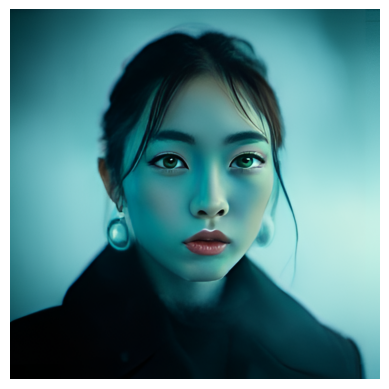

In [44]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Display the image
plt.imshow(janus_image[0])
plt.axis('off')  # Hide axes
plt.show()


## Flux

In [45]:
prompt = """(Portrait by Takashi Kijima and Lisa Barnard:1.2), award winning, Barioth , (aesthetic of hyperpop art with rippling atmosphere:0.5), fog, total clarity, f/1.4, symmetry and balance, avant-garde sublime opus magnum with splendid details, (salmon and phthalo turquoise colors:0.1), 
(Faye Wray:1.3), , 100mm f/2.8 macro lens, highly detailed,by Jocelyn Hobbie and Charles Dwyer, Triadic color guide,Leica Q2 with Summilux 28mm f/1.7 ASPH, ,clear face, Ultra High Resolution, wallpaper, 8K,Rich texture details, hyper detailed, detailed eyes, detailed background, dramatic angle, epic composition, SimplepositiveXLv1 (masterpiece, high quality, ),, solo, model photoshoot, (black theme:1.1), a stylish girl"""

In [49]:
import torch
from diffusers import FluxPipeline
import os

# Set the environment variable to help with memory fragmentation
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
# Clear CUDA cache and avoid tracking gradients
torch.cuda.empty_cache()

pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16)
pipe.enable_model_cpu_offload() #save some VRAM by offloading the model to CPU. Remove this if you have enough GPU power

image = pipe(
    prompt,
    height=1024,
    width=1024,
    guidance_scale=3.5,
    num_inference_steps=50,
    max_sequence_length=512,
    generator=torch.Generator("cpu").manual_seed(0)
).images[0]
image.save("flux-dev.png")


Loading pipeline components...: 100%|██████████| 7/7 [00:03<00:00,  1.93it/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (193 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['( faye wray : 1. 3 ),, 1 0 0 mm f / 2. 8 macro lens, highly detailed, by jocelyn hobbie and charles dwyer, triadic color guide, leica q 2 with summilux 2 8 mm f / 1. 7 asph,, clear face, ultra high resolution, wallpaper, 8 k, rich texture details, hyper detailed, detailed eyes, detailed background, dramatic angle, epic composition, simplepositivexlv 1 ( masterpiece, high quality, ),, solo, model photoshoot, ( black theme : 1. 1 ), a stylish girl']
100%|██████████| 50/50 [00:58<00:00,  1.18s/it]


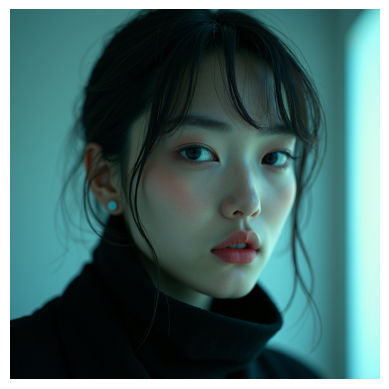

In [50]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


# Display the image
plt.imshow(image)
plt.axis('off')  # Hide axes
plt.show()


In [6]:
type(image)

PIL.Image.Image

In [7]:
image.size

(1024, 1024)